### Peer-graded Assignment (Part 1) - Babita Khanna
# Impact of Toronto neighborhood on its housing rentals
### Capstone Project - The Battle of Neighborhoods

### 1. Introduction

#### 1.1. Introduction to the Background


Toronto is the capital city of the Canadian province of Ontario and the largest city in Canada. With a recorded population of 6,341,935 in the Toronto region as reported by Toronto City Hall, it is the most populous city in Canada and the fourth most populous city in North America.

Toronto covers an area of 630 square kilometres (243 sq mi), with a maximum north–south distance of 21 kilometres (13 mi). The strength and vitality of the many neighbourhoods that make up Toronto, Ontario, Canada has earned the city its unofficial nickname of "the city of neighbourhoods". There are over 140 neighbourhoods officially recognized by the City of Toronto and upwards of 240 official and unofficial neighbourhoods within city limits.


#### 1.2. Business Problem Description 

Given its population census with the neighborhood variation, there is a huge demand of exploring different locations in Toronto city and its neighborhood by various stakeholders.

For an investor to launch their business, open up a restaurant or a coffee shop, there requires intense research and analysis to search for places with least competition and untapped opportunities for specific product demands or cuisines. Also, for people looking to reside in this popular city, they want to look into areas with specific neighborhood types such as parks & playgrounds for children, with least real estate values as well as specific criteria such as least dense population etc. as per their social preference. 

Considering to resolve such requirements at hand, the idea is to look into how we can use rental housing rates along with foursquare location data as well as the power of data science analytics to answer these questions proactively resolving the demand called out by the highlighted target audience.

### 2. Data

In order to resolve the business problem described, I have explored and used the below data sources:

<ol>
    <li> <b>Canadian Postal codes</b> was an excellent wiki site to retrive Toronto Neighborhood details. </li>
    <li> Comma Seperated Value file with <b>Geospatial Coordinates of all Toronto Neighborhood</b> to tag the neighborhood data with its location  - latitude and longitude information. </li>
    <li> Public information on Toronto renting index is not readily available. Hence, using the Housing Market Information Portal available on <b>Canada Mortgage and Housing Corporation</b>, I was able to gather rental property rates for each kind of accomodation for the past few years. Computing the average and relevant information, I have combined all the data sources of Canadian postal codes as well as the geospatial coordinates and represent the average housing range on the recorded properties. </li>
    <li> <b>Foursquare API</b> was used to extract the nearby venues for all combined neighborhood data. </li>
</ol>
    
Using these data sources, I have used to my best current ability to explore, analyze and resolve the business problem at hand. The following methodology section is a walk through of how the data described was investigated, used to create visulization maps, information charts and tables and plotted the rental data information on the map with its rate by clustering based on venue density. 


### 3. Methodology


First I have installed the necessary initial packages and wrangled online wiki data site consisting of Canadian postal codes.

In [1]:
!pip uninstall numpy -y
from bs4 import BeautifulSoup
import requests
!pip install numpy
import numpy as np
import pandas as pd

Found existing installation: numpy 1.18.5
Uninstalling numpy-1.18.5:
  Successfully uninstalled numpy-1.18.5
     |████████████████████████████████| 15.3 MB 12.6 MB/s eta 0:00:01


In [2]:
#Data Wrangling Part 1: Postal codes in Canada for retriving Toronto Neighborhood details
wikiurl="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html_data=requests.get(wikiurl).text
soup=BeautifulSoup(html_data,'html5lib')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"6811e43c-24f4-4775-9dca-49f86c4e75ff","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":1019189119,"wgRevisionId":1019189119,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Short description is different from Wikidata","Wikipedia

Once the data was wrangling, necessary pre-processing was done to add the required postal codes table with Borough and Neighborhood details into a dataframe <b>df</b>.

In [3]:
#Data Wrangling Part 2: Extracting table data into a DataFrame
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


Next, I have extracted the Geospatial coordinates via geopy to extract the latitude and longitude data. I merged the coordinates with the df dataframe and stored it into a new dataframe <b>dfloc</b>. The neighborhood data also had multiple lines of info in single cell. I seperated them using the function explode().

In [4]:
from geopy.geocoders import Nominatim

In [5]:
#Adding Latitude and Longitude information to the location dataframe
geolink='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv'
dfgeo=pd.read_csv(geolink)
dfloc = df.merge(dfgeo, how='inner', left_on='PostalCode', right_on='Postal Code')
dfloc.drop(["Postal Code"],axis=1,inplace=True)

In [6]:
#Splitting Neighborhood into multiple rows
dfloc=dfloc.assign(Neighborhood=df.Neighborhood.str.split(",")).explode("Neighborhood")
dfloc.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor,43.718518,-79.464763


Next I explored the Housing Market Information Portal available on Canada Mortgage and Housing Corporation to gather and extract rental property rates for each kind of accomodation in a new dataframe <b>df_rent</b>.

In [7]:
#Extracting Toronto rental data and adding it to a DataFrame
renturl="https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart/TableMatchingCriteria?GeographyType=MetropolitanMajorArea&GeographyId=2270&CategoryLevel1=Primary%20Rental%20Market&CategoryLevel2=Average%20Rent%20%28%24%29&ColumnField=2&RowField=24"
list_rent=pd.read_html(renturl)
df_rent=list_rent[0]
df_rent.head()

,Unnamed: 0,Bachelor,Bachelor.1,1 Bedroom,1 Bedroom.1,2 Bedroom,2 Bedroom.1,3 Bedroom +,3 Bedroom +.1,Total,Total.1
0,Agincourt/Malvern,**,NaN,1237,b,1395,b,1589,a,1408,b
1,Ajax/Pickering,**,NaN,1198,b,1362,a,1506,a,1412,a
2,Alderwood,**,NaN,1238,b,1451,c,**,NaN,1410,c
3,Aurora,**,NaN,1297,a,1543,a,**,NaN,1492,b
4,Banbury-Don Mills/York Mills,933,c,1464,a,1701,b,2018,a,1628,b


I, then, used the explode() function again to split the neighborhood details from the rental housing dataframe, renamed necessary columns and merged the dataframe with the dfloc dataframe combining all the data together based on the unique neighborhood information. All the required data is now available in the new dataframe <b>final_df</b>.

In [8]:
#Splitting the neighborhood data into rows
df_rent.rename(columns={"Unnamed: 0":"Neighborhood"},inplace=True)
df_rent=df_rent.assign(Neighborhood=df.Neighborhood.str.split("/")).explode("Neighborhood")
df_rent=df_rent.assign(Neighborhood=df.Neighborhood.str.split(",")).explode("Neighborhood")
df_rent = df_rent.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_rent.head()

,Neighborhood,Bachelor,Bachelor.1,1 Bedroom,1 Bedroom.1,2 Bedroom,2 Bedroom.1,3 Bedroom +,3 Bedroom +.1,Total,Total.1
0,Parkwoods,**,NaN,1237,b,1395,b,1589,a,1408,b
1,Victoria Village,**,NaN,1198,b,1362,a,1506,a,1412,a
2,Regent Park,**,NaN,1238,b,1451,c,**,NaN,1410,c
2,Harbourfront,**,NaN,1238,b,1451,c,**,NaN,1410,c
3,Lawrence Manor,**,NaN,1297,a,1543,a,**,NaN,1492,b


In [9]:
#Combining both DataFrames together and refining columns
stg_df = dfloc.merge(df_rent, how='inner', left_on='Neighborhood', right_on='Neighborhood') #joining dataframes
stg_df.dropna(axis=0,inplace=True) #removing any null values
stg_df.reset_index(inplace=True) #resetting index
final_df=pd.DataFrame([stg_df.Neighborhood,stg_df.Borough,stg_df.Latitude,stg_df.Longitude,stg_df.Bachelor,stg_df["1 Bedroom"],stg_df["2 Bedroom"],stg_df["3 Bedroom +"]]).transpose() #extracting only relevant columns
final_df.rename(columns={"Bachelor":"Studio","1 Bedroom":"1BHK","2 Bedroom":"2BHK","3 Bedroom +":"3BHK+"},inplace=True) #renaming columns
final_df.head()

,Neighborhood,Borough,Latitude,Longitude,Studio,1BHK,2BHK,3BHK+
0,Ontario Provincial Government,Queen's Park,43.662301,-79.389494,933,1464,1701,2018
1,Garden District,Downtown Toronto,43.657162,-79.378937,1037,1246,1655,2137
2,West Deane Park,Etobicoke,43.650943,-79.554724,1195,1243,1356,1482
3,Don Mills South,North York,43.7259,-79.340923,1091,1281,1433,1647
4,Woodbine Heights,East York,43.695344,-79.318389,962,1003,1197,1493


Now we have our raw data to work on, the first best step is to visualize the rental rates on a plotted graph to understand what is going on. I used histogram to plot each type of accomodation and overlapped them for better perception.

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

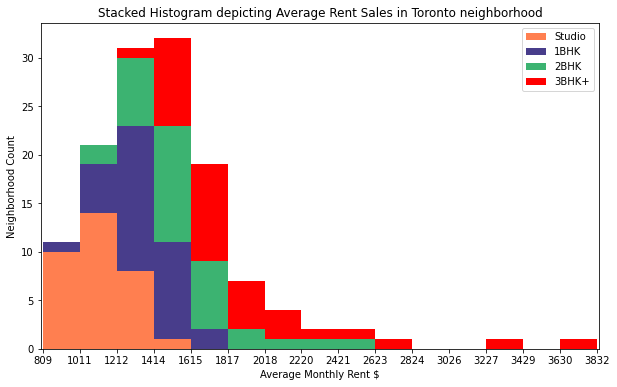

In [11]:
#Analyzing Rental Data using stacked histogram

final_df["Studio"] = final_df["Studio"].astype(float)
final_df["1BHK"] = final_df["1BHK"].astype(float)
final_df["2BHK"] = final_df["2BHK"].astype(float)
final_df["3BHK+"] = final_df["3BHK+"].astype(float)

final_df_hist=final_df.copy()
final_df_hist.drop(["Borough","Latitude","Longitude"],axis=1,inplace=True)
final_df_hist.set_index("Neighborhood",inplace=True)

count, bin_edges = np.histogram(final_df_hist, 15)
xmin = bin_edges[0] - 10   
xmax = bin_edges[-1] + 10 

final_df_hist.plot(kind='hist',
          figsize=(10, 6), 
          bins=15,
          xticks=bin_edges,
          color=['coral', 'darkslateblue', 'mediumseagreen','red'],
          stacked=True,
          xlim=(xmin, xmax)
         )

plt.title('Stacked Histogram depicting Average Rent Sales in Toronto neighborhood')
plt.ylabel('Neighborhood Count')
plt.xlabel('Average Monthly Rent $') 

plt.show()

Here, we can see that most of the rental property rates are at the start of the graph showing that the most housing rates are now considerabling lower. One reason could be th 2020 pandemic situation, where the economy is wavering and the canadian currently rate is also running strong. I will now divide the average of these housing rent rates into four ranges - 
- Low Monthly Rent
- Low-Medium Monthly Rent
- High-Medium Monthly Rent
- High Monthly Rent
<br>
<br>
I have added another column to the dataframe to label each row with these ranges based on the rent prices.

In [12]:
#Adding rent range labels to the rental data
rent_label_df=final_df.loc[:,["Neighborhood","Studio","1BHK","2BHK","3BHK+"]]
rent_label_df["Average Rent"]=rent_label_df.mean(axis=1)

rentbins=np.linspace(min(rent_label_df["Average Rent"]),max(rent_label_df["Average Rent"]),5)
groupnames=["Low Monthly Rent","Low-Medium Monthly Rent","High-Medium Monthly Rent","High Monthly Rent"]
rent_label_df["Rent Price Level"]=pd.cut(rent_label_df["Average Rent"],rentbins,labels=groupnames,include_lowest=True)
rent_label_df.drop(["Studio","1BHK","2BHK","3BHK+"],axis=1,inplace=True)

final_df = pd.merge(left=final_df, right=rent_label_df, left_on='Neighborhood', right_on='Neighborhood')
final_df.head()

,Neighborhood,Borough,Latitude,Longitude,Studio,1BHK,2BHK,3BHK+,Average Rent,Rent Price Level
0,Ontario Provincial Government,Queen's Park,43.662301,-79.389494,933.0,1464.0,1701.0,2018.0,1529.00,Low-Medium Monthly Rent
1,Garden District,Downtown Toronto,43.657162,-79.378937,1037.0,1246.0,1655.0,2137.0,1518.75,Low-Medium Monthly Rent
2,West Deane Park,Etobicoke,43.650943,-79.554724,1195.0,1243.0,1356.0,1482.0,1319.00,Low Monthly Rent
3,Don Mills South,North York,43.7259,-79.340923,1091.0,1281.0,1433.0,1647.0,1363.00,Low Monthly Rent
4,Woodbine Heights,East York,43.695344,-79.318389,962.0,1003.0,1197.0,1493.0,1163.75,Low Monthly Rent


Here, I calculate total number of neighborhood rentals based on their rent price levels.

In [13]:
rent_percent=final_df['Rent Price Level'].value_counts().to_frame()
rent_percent.rename(columns={'Rent Price Level':'Total Rental Spaces'},inplace=True)
rent_percent['Total Rental Spaces']=rent_percent['Total Rental Spaces'].astype(int)
rent_percent.head()

,Total Rental Spaces
Low Monthly Rent,20
Low-Medium Monthly Rent,10
High-Medium Monthly Rent,3
High Monthly Rent,2


Next, I will display all neighborhood pinpoints on a map to visual its locations. For this I will use the geolocator in order to retrieve the longitude and latitude coordinates for Toronto city.

In [14]:
#Retrieving geographical coordinates of Toronto for base map for Folium

address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto city are 43.6534817, -79.3839347.


In [15]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::ibm-wsrt-py37main-main==custom=2155
  - defaults/noarch::ibm-wsrt-py37main-keep==0.0.0=2155
  - conda-forge/linux-64::pytorch==1.8.0=cpu_py37ha70c682_1
done

# All requested packages already installed.



In [16]:
#Toronto map displaying neighborhood locations with rental data

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, neighborhood, borough in zip(final_df['Latitude'], final_df['Longitude'], final_df['Neighborhood'], final_df['Borough']):
    label = '{}, {}'.format(borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

To further explore the neighborhood locations, I have utilized FourSquare API to retrieve all nearby venues of each location by creating a function <b>getNearbyVenues()</b>.

In [17]:
#Defining Client ID and Secret to retrieve foursquare data

CLIENT_ID = '2RE0UZX2SWMID4IRO0BKL005NMKUWAPUAKOLKNTGMCGV21F1'
CLIENT_SECRET = 'MO24RXCM5ACCKOJJPSA5JQUGLLOFBR3E14X3B0Q4QUH3AZM3'
VERSION = '20210501'
LIMIT = 100

In [18]:
import json
import requests

In [19]:
#Function created for retrieving venues from foursquare

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We will now call the function by passing the neighborhood location coordinates from the final_df dataframe.

In [20]:
#Calling the function to fetch nearby venues of Toronto city

toronto_venues = getNearbyVenues(names=final_df['Neighborhood'],
                                   latitudes=final_df['Latitude'],
                                   longitudes=final_df['Longitude']
                                  )

Ontario Provincial Government
Garden District
West Deane Park
Don Mills South
Woodbine Heights
Humewood-Cedarvale
Central Bay Street
Christie
Thorncliffe Park
Dufferin
Scarborough Village
Northwood Park
Little Portugal
Toronto Dominion Centre
Golden Mile
Commerce Court
Downsview Central
Humberlea
Lawrence Park
Runnymede
Runnymede
Runnymede
Runnymede
Davisville North
Kingsview Village
Davisville
University of Toronto
Milliken
Summerhill West
Steeles West
Enclave of M5E
Upper Rouge
Church and Wellesley
Enclave of M4L
Mimico NW


Here we will have a look at the resulting dataframe <b>toronto_venues</b>.

In [21]:
print("Received",toronto_venues.shape[0],"results!")
toronto_venues.head()

Received 935 results!


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ontario Provincial Government,43.662301,-79.389494,Queen's Park,43.663946,-79.392180,Park
1,Ontario Provincial Government,43.662301,-79.389494,Mercatto,43.660391,-79.387664,Italian Restaurant
2,Ontario Provincial Government,43.662301,-79.389494,NEO COFFEE BAR,43.660130,-79.385830,Coffee Shop
3,Ontario Provincial Government,43.662301,-79.389494,Bar Volo,43.665462,-79.385692,Beer Bar
4,Ontario Provincial Government,43.662301,-79.389494,T-Swirl Crepe,43.663452,-79.384125,Creperie


I have summarized all the venues per Neighborhood into a new dataframe <b>grouped_venues</b> and plotted a bar chart to analyze it visually.

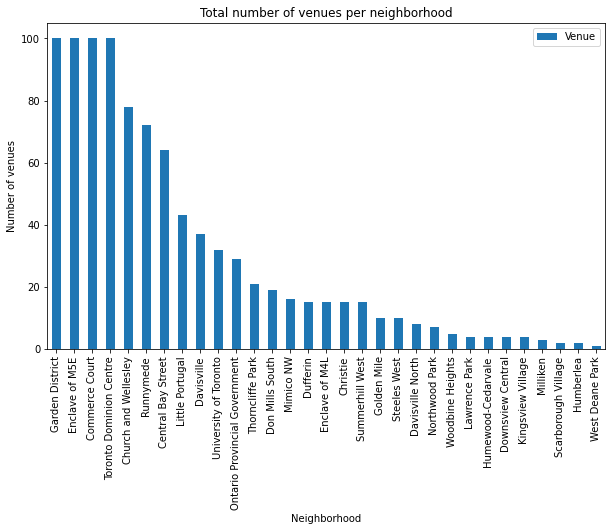

In [22]:
#Analyzing venue count for each neighbourhood and plotting it on bar chart

grouped_venues=toronto_venues.groupby('Neighborhood').count()
grouped_venues.reset_index(inplace=True)
grouped_venues=pd.DataFrame([grouped_venues["Neighborhood"],grouped_venues["Venue"]]).transpose()
grouped_venues.sort_values(by=['Venue'],inplace=True,ascending=False)
grouped_venues.set_index("Neighborhood",inplace=True)

grouped_venues.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Neighborhood')
plt.ylabel('Number of venues')
plt.title('Total number of venues per neighborhood')

plt.show()

From the bar chart, we understand that the Garden District, MSE Enclave, Commerce Court & Toronto Dominion Centre have reached the limit of 100 venues while West Deane Park, Humberlea, Scarborough Village, Mililiken, Kingsview Village and few others have way less than 10 nearby venues. Based on our geographical coordinates information, the inquiry result may vary. We can increase the possibility of much more information with more accurate geocoordinates. 

We will now analyze each neighborhood with the venue information using one hot encoding.

In [23]:
# One Hot encoding for the venue categories retrieved
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

#Rearranging column
first_column=toronto_onehot.pop("Neighborhood")
toronto_onehot.insert(0,"Neighborhood",first_column)

toronto_onehot.head()

,Neighborhood,Adult Boutique,American Restaurant,Antique Shop,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Workshop,Baby Store,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Yoga Studio
0,Ontario Provincial Government,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ontario Provincial Government,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ontario Provincial Government,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ontario Provincial Government,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ontario Provincial Government,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For better analysis, I have normalized the count of each of these venues, extracted the top 10 venues of each neighborhood and stored the results into a new dataframe <b>neighborhoods_venues_sorted</b>.

In [24]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Adult Boutique,American Restaurant,Antique Shop,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Workshop,Baby Store,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Yoga Studio
0,Central Bay Street,0.000000,0.000000,0.00,0.000000,0.015625,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.00,0.015625,0.00000,0.000000,0.000000,0.015625,0.0000,0.015625
1,Christie,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.00,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000
2,Church and Wellesley,0.012821,0.012821,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.025641
3,Commerce Court,0.000000,0.030000,0.00,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.00,0.020000,0.00000,0.000000,0.000000,0.010000,0.0000,0.000000
4,Davisville,0.000000,0.027027,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.027027,0.00,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000
5,Davisville North,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000
6,Don Mills South,0.000000,0.000000,0.00,0.052632,0.000000,0.052632,0.000000,0.000000,0.000000,...,0.000000,0.00,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000
7,Downsview Central,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000
8,Dufferin,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000
9,Enclave of M4L,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,...,0.000000,0.00,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000


In [25]:
#New dataframe with top 10 venues for each neighborhood

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Salad Place,Burger Joint,Bubble Tea Shop,Ice Cream Shop,Portuguese Restaurant,Comic Shop
1,Christie,Grocery Store,Café,Park,Candy Store,Restaurant,Italian Restaurant,Baby Store,Coffee Shop,Nightclub,Music Venue
2,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Yoga Studio,Pub,Hotel,Mediterranean Restaurant,Men's Store
3,Commerce Court,Coffee Shop,Restaurant,Hotel,Café,Gym,Italian Restaurant,American Restaurant,Seafood Restaurant,Deli / Bodega,Cocktail Bar
4,Davisville,Sandwich Place,Pizza Place,Dessert Shop,Café,Italian Restaurant,Coffee Shop,Gym,Sushi Restaurant,Gas Station,Fried Chicken Joint


Now that the venue information ready, I plan to use the k means clustering to group and segment the neighborhood. Before we do that, to accurately assign the number of clusters to divide them into, I will use the elbow method.

In [26]:
from sklearn.cluster import KMeans

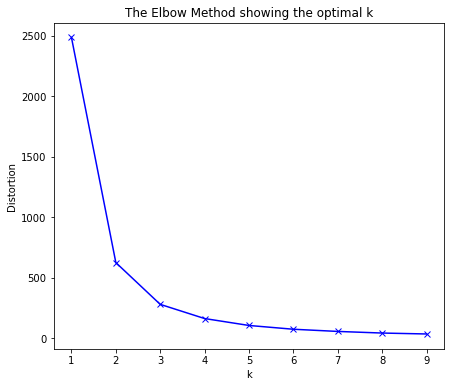

In [27]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
toronto_grouped_clustering.reset_index(inplace=True)

#Analyzing closest cluster count using k-means elbow method
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(7,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

As you can see, the best elbow point is at k=3. Hence I merge both the final_df dataframe with the neighborhood rent data infomation and neighborhoods_venues_sorted dataframe with top 10 venues into a new dataframe <b>toronto_merged</b>. Then we use the k means to divide the dataframe into 3 clusters by adding additional column <b>CLuster Labels</b>.

In [28]:
#Using the elbow method, dividing the dataframe into four clusters
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [29]:
#Adding clustering labels and merging with the dataframe with rental data

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = final_df.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(axis=0,inplace=True)
toronto_merged.reset_index(inplace=True)
toronto_merged.drop(["index"],axis=1,inplace=True)
toronto_merged["Cluster Labels"] = toronto_merged["Cluster Labels"].astype(int)
toronto_merged.head()

,Neighborhood,Borough,Latitude,Longitude,Studio,1BHK,2BHK,3BHK+,Average Rent,Rent Price Level,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ontario Provincial Government,Queen's Park,43.662301,-79.389494,933.0,1464.0,1701.0,2018.0,1529.00,Low-Medium Monthly Rent,...,Coffee Shop,Sushi Restaurant,Yoga Studio,Theater,Discount Store,Diner,Park,Creperie,Sandwich Place,College Cafeteria
1,Garden District,Downtown Toronto,43.657162,-79.378937,1037.0,1246.0,1655.0,2137.0,1518.75,Low-Medium Monthly Rent,...,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Cosmetics Shop,Café,Bubble Tea Shop,Japanese Restaurant,Italian Restaurant,Ramen Restaurant,Burger Joint
2,West Deane Park,Etobicoke,43.650943,-79.554724,1195.0,1243.0,1356.0,1482.0,1319.00,Low Monthly Rent,...,Bakery,Adult Boutique,New American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater
3,Don Mills South,North York,43.7259,-79.340923,1091.0,1281.0,1433.0,1647.0,1363.00,Low Monthly Rent,...,Restaurant,Gym,Coffee Shop,Discount Store,Sandwich Place,Clothing Store,Chinese Restaurant,Sporting Goods Shop,Supermarket,Bike Shop
4,Woodbine Heights,East York,43.695344,-79.318389,962.0,1003.0,1197.0,1493.0,1163.75,Low Monthly Rent,...,Curling Ice,Park,Intersection,Skating Rink,Beer Store,Music Venue,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant


To visualize these clusters, I have plotted a folium map and pinpointed the neighborhood locations by colored circle markers per cluster.

In [30]:
#Creating a map displaying the clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

I have also displayed the list of neighborhood per cluster below.

In [31]:
#Displaying 1st cluster
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(3, toronto_merged.shape[1]))]]

,Borough,Longitude,Studio,1BHK,2BHK,3BHK+,Average Rent,Rent Price Level,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,North York,-79.340923,1091.0,1281.0,1433.0,1647.0,1363.00,Low Monthly Rent,0,Restaurant,Gym,Coffee Shop,Discount Store,Sandwich Place,Clothing Store,Chinese Restaurant,Sporting Goods Shop,Supermarket,Bike Shop
6,Downtown Toronto,-79.387383,1327.0,1609.0,2301.0,3832.0,2267.25,High Monthly Rent,0,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Salad Place,Burger Joint,Bubble Tea Shop,Ice Cream Shop,Portuguese Restaurant,Comic Shop
7,Downtown Toronto,-79.422564,1385.0,1558.0,1708.0,1969.0,1655.00,Low-Medium Monthly Rent,0,Grocery Store,Café,Park,Candy Store,Restaurant,Italian Restaurant,Baby Store,Coffee Shop,Nightclub,Music Venue
9,West Toronto,-79.442259,984.0,1374.0,1581.0,1722.0,1415.25,Low Monthly Rent,0,Bakery,Pharmacy,Café,Music Venue,Liquor Store,Brewery,Bar,Bank,Grocery Store,Park
15,Downtown Toronto,-79.379817,1199.0,1468.0,1713.0,2169.0,1637.25,Low-Medium Monthly Rent,0,Coffee Shop,Restaurant,Hotel,Café,Gym,Italian Restaurant,American Restaurant,Seafood Restaurant,Deli / Bodega,Cocktail Bar
16,North York,-79.495697,1191.0,1531.0,1996.0,2740.0,1864.50,High-Medium Monthly Rent,0,Home Service,Business Service,Food Truck,Baseball Field,Pizza Place,Pharmacy,Plaza,Playground,Middle Eastern Restaurant,Miscellaneous Shop
23,Central Toronto,-79.390197,1130.0,1493.0,1679.0,1875.0,1544.25,Low-Medium Monthly Rent,0,Food & Drink Shop,Hotel,Playground,Department Store,Pizza Place,Park,Breakfast Spot,Sandwich Place,Museum,Middle Eastern Restaurant
25,Central Toronto,-79.38879,1055.0,1399.0,1569.0,1815.0,1459.50,Low-Medium Monthly Rent,0,Sandwich Place,Pizza Place,Dessert Shop,Café,Italian Restaurant,Coffee Shop,Gym,Sushi Restaurant,Gas Station,Fried Chicken Joint
31,Downtown Toronto,-79.38316,1071.0,1021.0,1130.0,1366.0,1147.00,Low Monthly Rent,0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Yoga Studio,Pub,Hotel,Mediterranean Restaurant,Men's Store
32,East Toronto Business,-79.321558,1109.0,1383.0,1591.0,1842.0,1481.25,Low-Medium Monthly Rent,0,Light Rail Station,Spa,Skate Park,Farmers Market,Garden Center,Brewery,Comic Shop,Burrito Place,Gym / Fitness Center,Auto Workshop


In [32]:
#Displaying 2nd cluster
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(3, toronto_merged.shape[1]))]]

,Borough,Longitude,Studio,1BHK,2BHK,3BHK+,Average Rent,Rent Price Level,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queen's Park,-79.389494,933.0,1464.0,1701.0,2018.0,1529.00,Low-Medium Monthly Rent,1,Coffee Shop,Sushi Restaurant,Yoga Studio,Theater,Discount Store,Diner,Park,Creperie,Sandwich Place,College Cafeteria
2,Etobicoke,-79.554724,1195.0,1243.0,1356.0,1482.0,1319.00,Low Monthly Rent,1,Bakery,Adult Boutique,New American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater
4,East York,-79.318389,962.0,1003.0,1197.0,1493.0,1163.75,Low Monthly Rent,1,Curling Ice,Park,Intersection,Skating Rink,Beer Store,Music Venue,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant
8,East York,-79.349372,1014.0,1298.0,1421.0,1556.0,1322.25,Low Monthly Rent,1,Indian Restaurant,Sandwich Place,Yoga Studio,Bank,Coffee Shop,Fast Food Restaurant,Supermarket,Burger Joint,Liquor Store,Gas Station
10,Scarborough,-79.239476,1010.0,1232.0,1461.0,1717.0,1355.00,Low Monthly Rent,1,Health & Beauty Service,Playground,Adult Boutique,Music Venue,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark
11,North York,-79.487262,1075.0,1442.0,1579.0,1720.0,1454.00,Low-Medium Monthly Rent,1,Metro Station,Caribbean Restaurant,Massage Studio,Furniture / Home Store,Falafel Restaurant,Bar,Coffee Shop,Music Venue,Modern European Restaurant,Molecular Gastronomy Restaurant
13,Downtown Toronto,-79.381576,1291.0,1197.0,1383.0,1723.0,1398.50,Low Monthly Rent,1,Coffee Shop,Hotel,Café,Salad Place,Italian Restaurant,Restaurant,Seafood Restaurant,Japanese Restaurant,Gastropub,Deli / Bodega
19,York,-79.487262,1282.0,1318.0,1409.0,1596.0,1401.25,Low Monthly Rent,1,Coffee Shop,Café,Pizza Place,Italian Restaurant,Sushi Restaurant,Pub,Diner,Smoothie Shop,Convenience Store,Sandwich Place
20,York,-79.487262,1282.0,1318.0,1409.0,1596.0,1401.25,Low Monthly Rent,1,Coffee Shop,Café,Pizza Place,Italian Restaurant,Sushi Restaurant,Pub,Diner,Smoothie Shop,Convenience Store,Sandwich Place
21,West Toronto,-79.48445,1282.0,1318.0,1409.0,1596.0,1401.25,Low Monthly Rent,1,Coffee Shop,Café,Pizza Place,Italian Restaurant,Sushi Restaurant,Pub,Diner,Smoothie Shop,Convenience Store,Sandwich Place


In [33]:
#Displaying 3rd cluster
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(3, toronto_merged.shape[1]))]]

,Borough,Longitude,Studio,1BHK,2BHK,3BHK+,Average Rent,Rent Price Level,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Downtown Toronto,-79.378937,1037.0,1246.0,1655.0,2137.0,1518.75,Low-Medium Monthly Rent,2,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Cosmetics Shop,Café,Bubble Tea Shop,Japanese Restaurant,Italian Restaurant,Ramen Restaurant,Burger Joint
5,York,-79.428191,966.0,1262.0,1447.0,1642.0,1329.25,Low Monthly Rent,2,Hockey Arena,Field,Trail,Moving Target,Adult Boutique,Music Venue,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant
12,West Toronto,-79.41975,932.0,1192.0,1353.0,1543.0,1255.00,Low Monthly Rent,2,Bar,Coffee Shop,Asian Restaurant,Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Men's Store,Café,New American Restaurant,Cuban Restaurant
14,Scarborough,-79.284577,1013.0,1242.0,1485.0,1809.0,1387.25,Low Monthly Rent,2,Bus Line,Bakery,Metro Station,Intersection,Soccer Field,Park,Bus Station,Ice Cream Shop,Pharmacy,Moving Target
17,North York,-79.532242,1044.0,1312.0,1481.0,1582.0,1354.75,Low Monthly Rent,2,Food Service,Baseball Field,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target
18,Central Toronto,-79.38879,809.0,1256.0,1514.0,1521.0,1275.00,Low Monthly Rent,2,Dim Sum Restaurant,Park,Swim School,Bus Line,Adult Boutique,Museum,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant
24,Etobicoke,-79.554724,835.0,1172.0,1343.0,1625.0,1243.75,Low Monthly Rent,2,Bus Line,Pizza Place,Park,Sandwich Place,Music Venue,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant
27,Scarborough,-79.284577,1225.0,1498.0,2015.0,2296.0,1758.50,High-Medium Monthly Rent,2,Playground,Park,Intersection,Adult Boutique,Music Venue,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant
30,Downtown Toronto Stn A,-79.374846,1007.0,1194.0,1383.0,1629.0,1303.25,Low Monthly Rent,2,Coffee Shop,Cocktail Bar,Seafood Restaurant,Hotel,Beer Bar,Restaurant,Bakery,Café,Japanese Restaurant,Italian Restaurant
33,Etobicoke,-79.520999,1004.0,1248.0,1440.0,1605.0,1324.25,Low Monthly Rent,2,Fast Food Restaurant,Burrito Place,Wings Joint,Discount Store,Supplement Shop,Burger Joint,Flower Shop,Tanning Salon,Convenience Store,Hardware Store


To view more summarized information visually, I planned to add two more labels to the dataframe - one for the type of neighborhood type based on the most popular type of venues and another for displaying top 3 venues in one column. For the neighborhood type column information, I have plotted the venue count for the neighborhoods based on the cluster.

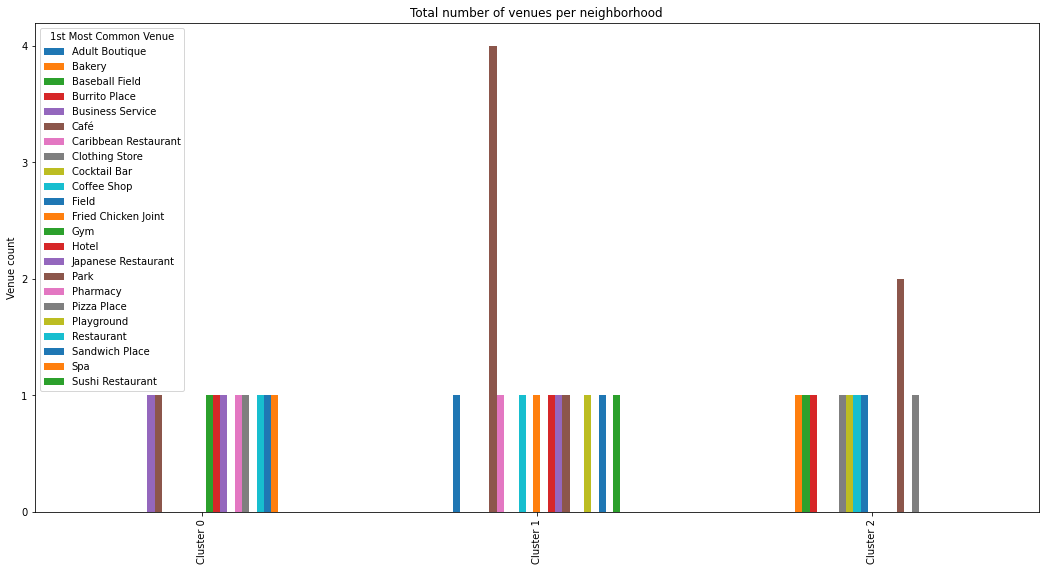

In [34]:
#Displaying top most venue in the neighborhood for each cluster

clus_onehot=toronto_merged.loc[:,["Neighborhood","1st Most Common Venue","Cluster Labels"]]
clus_onehot = pd.get_dummies(clus_onehot["Cluster Labels"])
clus_onehot['Neighborhood'] = toronto_merged['Neighborhood']
clus_onehot['1st Most Common Venue'] = toronto_merged['1st Most Common Venue']
clus_onehot.rename(columns={0:"Cluster 0",1:"Cluster 1",2:"Cluster 2"},inplace=True)


#clus_venue_bar=toronto_merged.loc[:,["1st Most Common Venue","Cluster Labels"]]
clus_venue_bar=clus_onehot.groupby(['1st Most Common Venue']).sum()
clus_venue_bar.reset_index(inplace=True)
clus_venue_bar.set_index('1st Most Common Venue',inplace=True)
clus_venue_bar = clus_venue_bar.transpose()

clus_venue_bar.plot(kind='bar', figsize=(18, 9))

plt.ylabel('Venue count')
plt.title('Total number of venues per neighborhood')

yint = range(0,5)
plt.yticks(yint)

plt.show()

Based on the bar chart above, I have added the Neighborhood type column with each cluster renamed as:
- Cafe and Gym Venues
- Dine-in Restaurants
- Parks, Playgrounds & Good Transport Service
<br>

In [35]:
#Labelling the dataframe with cluster type
clus_label_df=toronto_merged.loc[:,["Neighborhood","Cluster Labels"]]
clus_label_df["Neighborhood Type"]=clus_label_df["Cluster Labels"]
clus_label_df["Neighborhood Type"].replace({0: "Dine-in Restaurants", 1: "Cafe and Gym Venues", 2: "Parks, Playgrounds & Good Transport Service"}, inplace=True)
clus_label_df.drop(["Cluster Labels"],axis=1,inplace=True)
toronto_merged=pd.merge(left=toronto_merged, right=clus_label_df, left_on='Neighborhood', right_on='Neighborhood')
toronto_merged.head()

,Neighborhood,Borough,Latitude,Longitude,Studio,1BHK,2BHK,3BHK+,Average Rent,Rent Price Level,...,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Neighborhood Type
0,Ontario Provincial Government,Queen's Park,43.662301,-79.389494,933.0,1464.0,1701.0,2018.0,1529.00,Low-Medium Monthly Rent,...,Sushi Restaurant,Yoga Studio,Theater,Discount Store,Diner,Park,Creperie,Sandwich Place,College Cafeteria,Cafe and Gym Venues
1,Garden District,Downtown Toronto,43.657162,-79.378937,1037.0,1246.0,1655.0,2137.0,1518.75,Low-Medium Monthly Rent,...,Clothing Store,Middle Eastern Restaurant,Cosmetics Shop,Café,Bubble Tea Shop,Japanese Restaurant,Italian Restaurant,Ramen Restaurant,Burger Joint,"Parks, Playgrounds & Good Transport Service"
2,West Deane Park,Etobicoke,43.650943,-79.554724,1195.0,1243.0,1356.0,1482.0,1319.00,Low Monthly Rent,...,Adult Boutique,New American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Cafe and Gym Venues
3,Don Mills South,North York,43.7259,-79.340923,1091.0,1281.0,1433.0,1647.0,1363.00,Low Monthly Rent,...,Gym,Coffee Shop,Discount Store,Sandwich Place,Clothing Store,Chinese Restaurant,Sporting Goods Shop,Supermarket,Bike Shop,Dine-in Restaurants
4,Woodbine Heights,East York,43.695344,-79.318389,962.0,1003.0,1197.0,1493.0,1163.75,Low Monthly Rent,...,Park,Intersection,Skating Rink,Beer Store,Music Venue,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Cafe and Gym Venues


Now I have further added another column for top 3 nearby venues collated.

In [36]:
#Adding column with top 3 nearby venues label
result_df=toronto_merged.copy()
cols = ['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']
result_df['Top 3 Nearby Venues'] = result_df[cols].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
result_df.drop(result_df.loc[:,'1st Most Common Venue':'10th Most Common Venue'].columns, axis=1,inplace=True)
result_df.head()

,Neighborhood,Borough,Latitude,Longitude,Studio,1BHK,2BHK,3BHK+,Average Rent,Rent Price Level,Cluster Labels,Neighborhood Type,Top 3 Nearby Venues
0,Ontario Provincial Government,Queen's Park,43.662301,-79.389494,933.0,1464.0,1701.0,2018.0,1529.00,Low-Medium Monthly Rent,1,Cafe and Gym Venues,"Coffee Shop, Sushi Restaurant, Yoga Studio"
1,Garden District,Downtown Toronto,43.657162,-79.378937,1037.0,1246.0,1655.0,2137.0,1518.75,Low-Medium Monthly Rent,2,"Parks, Playgrounds & Good Transport Service","Coffee Shop, Clothing Store, Middle Eastern Re..."
2,West Deane Park,Etobicoke,43.650943,-79.554724,1195.0,1243.0,1356.0,1482.0,1319.00,Low Monthly Rent,1,Cafe and Gym Venues,"Bakery, Adult Boutique, New American Restaurant"
3,Don Mills South,North York,43.7259,-79.340923,1091.0,1281.0,1433.0,1647.0,1363.00,Low Monthly Rent,0,Dine-in Restaurants,"Restaurant, Gym, Coffee Shop"
4,Woodbine Heights,East York,43.695344,-79.318389,962.0,1003.0,1197.0,1493.0,1163.75,Low Monthly Rent,1,Cafe and Gym Venues,"Curling Ice, Park, Intersection"


Finally to display all details on a folium map, I have added a radius column for plotting purposes to add marker size based on the rent price for the particular neighborhood.

In [37]:
#For representing the average rent range in the final map
result_df['radius'] = result_df['Rent Price Level']

result_df['radius']=result_df['radius'].replace({'Low Monthly Rent':5,
                                             'Low-Medium Monthly Rent':8,
                                             'High-Medium Monthly Rent':12,'High Monthly Rent':15})
result_df.head()

,Neighborhood,Borough,Latitude,Longitude,Studio,1BHK,2BHK,3BHK+,Average Rent,Rent Price Level,Cluster Labels,Neighborhood Type,Top 3 Nearby Venues,radius
0,Ontario Provincial Government,Queen's Park,43.662301,-79.389494,933.0,1464.0,1701.0,2018.0,1529.00,Low-Medium Monthly Rent,1,Cafe and Gym Venues,"Coffee Shop, Sushi Restaurant, Yoga Studio",8
1,Garden District,Downtown Toronto,43.657162,-79.378937,1037.0,1246.0,1655.0,2137.0,1518.75,Low-Medium Monthly Rent,2,"Parks, Playgrounds & Good Transport Service","Coffee Shop, Clothing Store, Middle Eastern Re...",8
2,West Deane Park,Etobicoke,43.650943,-79.554724,1195.0,1243.0,1356.0,1482.0,1319.00,Low Monthly Rent,1,Cafe and Gym Venues,"Bakery, Adult Boutique, New American Restaurant",5
3,Don Mills South,North York,43.7259,-79.340923,1091.0,1281.0,1433.0,1647.0,1363.00,Low Monthly Rent,0,Dine-in Restaurants,"Restaurant, Gym, Coffee Shop",5
4,Woodbine Heights,East York,43.695344,-79.318389,962.0,1003.0,1197.0,1493.0,1163.75,Low Monthly Rent,1,Cafe and Gym Venues,"Curling Ice, Park, Intersection",5


In [38]:
#Representing the analyzed data on terrain map

final_map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Terrain')

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, neighborhood, rpl, nt, tnv, cluster, avgrent in zip(result_df['Latitude'], result_df['Longitude'], result_df['Neighborhood'], result_df['Rent Price Level'], result_df['Neighborhood Type'], result_df['Top 3 Nearby Venues'], result_df['Cluster Labels'], result_df['radius']):
    label = "{} > {}, Location famous for its {}, Top Nearby Venues: {}".format(neighborhood, rpl, nt, tnv)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=avgrent,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(final_map)
       
final_map

### 4. Results and Discussion

The final dataframe result df and the folium map is the accurate representation of the exploration and analysis of the raw data discussed at the start of this project.

Based on the rental data range, the neighborhood was also segmented into four tiers: Low Monthly Rent, Low-Medium Monthly Rent, High-Medium Monthly Rent and High Monthly Rent ranges. It was seen most of the neighborhood fall under the Low Monthly Rent tier followed by Low-Medium Monthly Rent tier.

With the help of the K-means algorithm elbow method, the optimum k value was 3 for the limited data for the clustering analysis. The data set can be expanded much more with finer neighborhood and street details for more detailed and accurate guidance.

There are three main clusters the complete neighborhood dataset has been segmented into where each are dominated by two-three types of venue categories. The first cluster 0 is known for its Pizza Parlours & Dine-in Restaurants, second cluster 1 for its Cafe and Gym Venues and the third cluster 2 for its Parks, Playgrounds & Good Transport Service. Another information value was added to the final result showing us the top three venues in each of the neighborhood allowing investors and future residents to choose and decide from.

As previously discussed, Toronto is the largest and most populous city in Canada within a narrow area. The total number of measurements and population densities of boroughs in total can vary. As there is such a complexity, very different approaches can be tried in clustering and classification studies. Moreover, it is obvious that not every classification method can yield the same high quality results for this city.

Future studies can be carried out using various available platforms and packages similarly to my data analysis with the available neighborhood geographical coordinates and housing market rent data. Where I have presented data visualization of the complete dataset on Toronto folium map, web applications can be built similarly reaching our directly to the targetted investors.

### 6. Conclusion

My motive through this project was to answer the questions investors and future residents that represents the preference of people turning to bigger cities to start a new business or set up a new life. Many can achieve way better outcomes through their access to such platforms where this information is provided. City or Town hall management and manager can also benefit by using such data analysis reports and platforms.